In [1]:
PATH ='/media/dat/dataset/YOUTUBE_BB/youtube_boundingboxes_detection_validation.csv'

In [2]:
import numpy as np
from utils.youtube_bb import get_video_ids
from IPython.display import YouTubeVideo

# Get all video ids that satisfies the condition as stated 
grouped = get_video_ids(PATH, 
                        category  = 'car', 
                        min_area  = 0.03, 
                        max_area  = 0.3, 
                        threshold = 0.1)

print("Number of videos: %s" % len(grouped))

Number of videos: 317


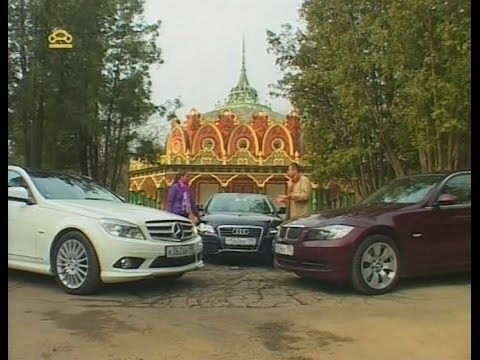

In [3]:
# Display an example
idx = np.random.randint(0, len(grouped.groups.keys()))
video_id = list(grouped.groups.keys())[idx]
video_id = 'jDGrgBt83DU'
# Download youtube video and save into /tmp/
YouTubeVideo(video_id)

In [4]:
# Good video_ids
# Mazda : pknTbsTDImE
# Audi 4 vs Merces:  jDGrgBt83DU

## Download video 

In [5]:
import os
import cv2
from pytube import YouTube

# Reference
# https://docs.opencv.org/3.3.0/d4/d15/group__videoio__flags__base.html

# Download video into /tmp
yt = YouTube('https://www.youtube.com/watch?v=%s' % video_id)
title  = yt.title
stream = yt.streams.filter(file_extension='mp4').first().download('/tmp')

## Process the video using AlexNet Conv3 and Consine Similarity

- Extract the foreground
- get conv-3
- compare the fist frame + last frame
- cosine similarity
- parameters : 3secs, threshold, 

- get clip --> AlexNet -->  calculate distance -->  stabilize video --> VIRAT pipeline
- detect motion blur --> ignore
- 

In [18]:
# -*- coding: utf8 -*-

import torch
import os
import numpy as np
from torch.nn.modules.distance import CosineSimilarity
import  matplotlib.pyplot as plt

class VideoAnalyzer(object):
    """
    Look for fixed-angle video sequences in a video
    """
    def __init__(self,
                 model        , 
                 data_transform ,
                 metric       = '',
                 stabilizer   = None):

        self.model      = model
        self.data_transform = data_transform
        self.metric     = metric
        self.stabilizer = stabilizer

    def process(self, video_path, sequence_len=50):
        
        print(os.path.isfile(video_path))
        
        cap    = cv2.VideoCapture(video_path)
        
        # Init video params (video length, width, height, fps)
        if cap.isOpened():
            param = self._set_video_params(cap)
            
        frame_size = (param['video_height'],param['video_width'],  3)
        fig = plt.figure(figsize=(8,4))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        fig.tight_layout()
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax3.set_title('Cosine Distance' , fontsize=7)
        b2 = fig.canvas.copy_from_bbox(ax2.bbox)
        im1 =  ax1.imshow(np.random.randint(0, 255, (256, 256, 3)))
        im2 =  ax2.imshow(np.random.randint(0, 255, (256, 256, 3)))
        heatmap =  ax3.imshow(np.random.randint(0, 255, (11,11, 3)))

        for curr_cursor in range(0 , param['video_length'], sequence_len):
            first_frame_idx =  curr_cursor 
            last_frame_idx  =  curr_cursor + sequence_len
            
            if last_frame_idx > param['video_length']:
                break
                
            cap.set(cv2.CAP_PROP_POS_FRAMES,  first_frame_idx)                             
            _, first_frame = cap.read()
            first_frame = cv2.cvtColor(first_frame,cv2.COLOR_BGR2RGB)

            cap.set(cv2.CAP_PROP_POS_FRAMES,  last_frame_idx)                             
            _, last_frame = cap.read()
            last_frame = cv2.cvtColor(last_frame,cv2.COLOR_BGR2RGB)

            if last_frame is None:
                break
        
            fst_frame = self.data_transform(first_frame)
            lst_frame = self.data_transform(last_frame)
            inputs  = torch.stack([fst_frame, lst_frame])
            
            # Shape: (2, 384, 11, 11)
            # Calculate feature maps of the two frames
            feat_maps = self.model(torch.autograd.Variable(inputs))
            
            # Shape: (27, 27)
            # Measure distance
            distance = self.metric(feat_maps[0], feat_maps[1])
            # Visualization
            im1.set_data(cv2.resize(first_frame, (256, 256)))
            im2.set_data(cv2.resize(last_frame, (256, 256)))
            heatmap.set_data(255*distance.data)
            
            fig.canvas.draw()
            time.sleep(0.01)
        plt.close(fig)
        cap.release()

    def _set_video_params(self, cap):
    
        params = {
            'video_length': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
            'video_width' : int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            'video_height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
            'video_fps'   : cap.get(cv2.CAP_PROP_FPS),
        }
        print("Video Duration: {:.2f} secs".format( params['video_length']/params['video_fps']))
        return params


True
Video Duration: 505.47 secs


<IPython.core.display.Javascript object>


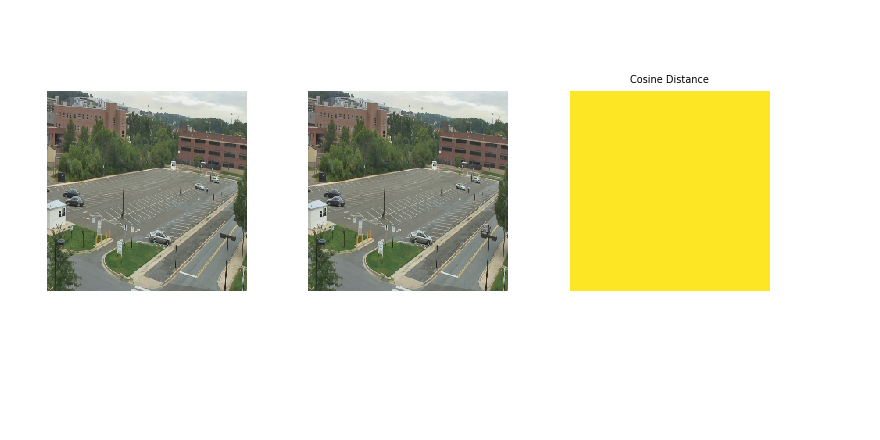

Processed in 39.11 secs


In [19]:
import time
from alexnet import alexnet_conv3, preprocessor
from torch.nn.modules.distance import CosineSimilarity
%matplotlib notebook

# VIDEO_FILE = '/tmp/%s.mp4'%title

VIDEO_FILE = '/media/dat/dataset/VIRAT/videos_original/VIRAT_S_000200_04_000937_001443.mp4'

video_analyzer    = VideoAnalyzer(model          = alexnet_conv3(pretrained=True), 
                                  metric         = CosineSimilarity(dim=0),
                                  data_transform = preprocessor())
start = time.time()
video_analyzer.process(VIDEO_FILE, sequence_len=50)
print("Processed in {:.2f} secs".format(time.time() - start))

In [ ]:
# import time
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import rcParams
# rcParams['figure.autolayout'] = True
# %matplotlib notebook

# img = cv2.cvtColor(cv2.imread('examples/cute_cat.jpg'), cv2.COLOR_BGR2RGB)
# frame_size = img.shape

# fig = plt.figure(figsize=(8,3))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)
# fig.tight_layout()
# ax1.axis('off')
# ax2.axis('off')

# im1 =  ax1.imshow(125*np.ones(frame_size))
# im2 =  ax2.imshow(125*np.ones(frame_size))

# fig.canvas.draw()
# b1 = fig.canvas.copy_from_bbox(ax1.bbox)
# b2 = fig.canvas.copy_from_bbox(ax2.bbox)
# print(ax2.images)

# start= time.time()
# for i in range(0,10):
#     img = np.random.randint(0, 255 , frame_size).astype(np.uint8)
    
#     im1.set_data(img)
#     im2.set_data(img)
    
#     fig.canvas.restore_region(b1)
#     fig.canvas.restore_region(b2)
    
#     ax1.draw_artist(im1)
#     ax2.draw_artist(im2)

#     fig.canvas.blit(ax1.bbox)
#     fig.canvas.blit(ax2.bbox)
# #     fig.canvas.draw()
    
# print("Completed in ", time.time() -start)